In [13]:
#Importing the required libraries ands set
import time
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from qiskit.tools.visualization import plot_histogram
# %config InlineBackend.figure_format='retina'
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator
# initialization
import matplotlib.pyplot as plt
import numpy as np
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
# import basic plot tools
from qiskit.visualization import plot_histogram


In [14]:
def bernstein_vazirani(string):
    
    # Save the length of string
    string_length = len(string)
    
    # Make a quantum circuit
    qc = QuantumCircuit(string_length+1, string_length)
    
    # Initialize each input qubit to apply a Hadamard gate and output qubit to |->
    
    qc.x(string_length)
    qc.h(string_length)
    for i in range(string_length):
        qc.h(i)
    
    #
    
    # Apply an oracle for the given string
    # Note: In Qiskit, numbers are assigned to the bits in a string from right to left
    s = string[::-1]
    for q in range(string_length):
        if s[q] == '0':
            qc.i(q)
        else:
            qc.cx(q, string_length)

    
    # Apply Hadamard gates after querying the oracle
    for i in range(string_length):
        qc.h(i)

    
    # Measurement
    qc.measure(range(string_length), range(string_length))
    
    return qc

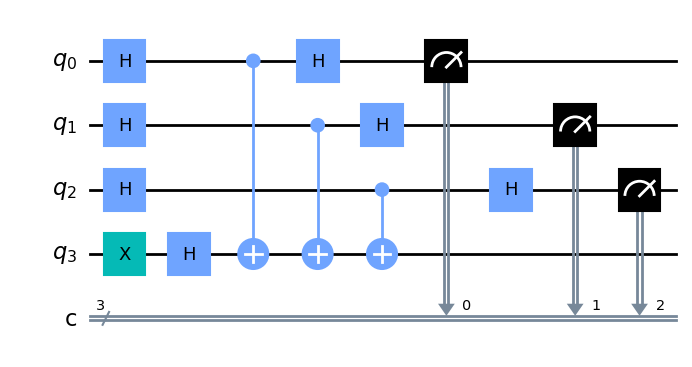

In [35]:
#example if we enter the hidden string '111' , you can test this using any bitstrings of 0 and 1 
qc1 = bernstein_vazirani('111')
display(qc1.draw(output="mpl"))

In [28]:
#First, let's set a backend to use. We shall be running our routines on the ibmq_qasm_simulator on cloud
backend = service.backends(simulator=True)[0]
print(backend)

<IBMBackend('ibmq_qasm_simulator')>


In [29]:
#Now let us build a session constructor here. We will make Session using with statement and define our Sampler instance to run our Bernstein-Vazirani circuits within this session. 
#The with statement here denotes a context manager that is used to pass in the service that we previously defined as the initial parameter for the constructor. 
#To submit a job with the Sampler, use run method specifying parameters within it. 
#It requires you to pass in circuits which can be either a single circuit or a list of QuantumCircuit. 
#The best feature of this structure is how quickly you can scale the number of circuits you pass by simply changing the list being passed to the Sampler run call.



options = Options(simulator={"seed_simulator": 42}, resilience_level=0) # Do not change values in simulator



In [37]:
#For a consistent result, we will set a seed for Sampler. 
#You can set the seed inside the Sampler object using options above. 
#The example of how to use options with Sampler is right below:

with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(circuits=[qc1])

In [38]:
#After running the sampler, it returns a RuntimeJob object and we can extract the results from this object using the result method to check the returned data. 
#We can then pick our individual data of interest from this returned result. 
#Details are here:https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.RuntimeJob.html#qiskit_ibm_runtime.RuntimeJob.
result = job.result()
result.quasi_dists

[{7: 1.0}]

In [44]:
# The hidden string of the circuit qc1 is 111 and the first result is 7 (7 in binary, 111). 
#Its probability is 1.0 and it means the circuit returns 7 for 100% sure.

In [45]:
#Running this on a real Quantum Computer

In [46]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2022-11-20 15:58:38,551: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_quito


In [47]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_qc1 = transpile(qc1, backend)
job = backend.run(transpiled_qc1, shots=shots)

job_monitor(job, interval=2)

Job Status: job has successfully run


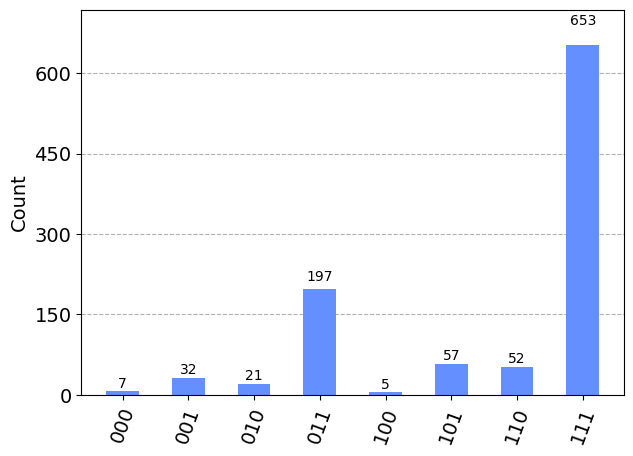

In [48]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In [ ]:
#As we can see, most of the results are 111. The other results are due to errors in the quantum computation.